In [3]:
# Importing essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load dataset
df = pd.read_csv('/content/admission_predict.csv')
print(" Loaded:", df.shape, "rows/cols")
df.head()

 Loaded: (500, 9) rows/cols


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
df.info()
display(df.describe().T)
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


,count,mean,std,min,25%,50%,75%,max
Serial No.,500.0,250.50000,144.481833,1.00,125.7500,250.50,375.25,500.00
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00
University Rating,500.0,3.11400,1.143512,1.00,2.0000,3.00,4.00,5.00
SOP,500.0,3.37400,0.991004,1.00,2.5000,3.50,4.00,5.00
LOR,500.0,3.48400,0.925450,1.00,3.0000,3.50,4.00,5.00
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92
Research,500.0,0.56000,0.496884,0.00,0.0000,1.00,1.00,1.00
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97


,0
Serial No.,0
GRE Score,0
TOEFL Score,0
University Rating,0
SOP,0
LOR,0
CGPA,0
Research,0
Chance of Admit,0


In [5]:
# Rename columns & drop Serial No.
df = df.rename(columns={
    'GRE Score':'GRE','TOEFL Score':'TOEFL','LOR ':'LOR','Chance of Admit ':'Probability'
})
if 'Serial No.' in df.columns:
    df.drop('Serial No.', axis=1, inplace=True)

# Replace structural zeros with NaN
num_cols = ['GRE','TOEFL','University Rating','SOP','LOR','CGPA']
df[num_cols] = df[num_cols].replace(0, np.nan)
print(df.isnull().sum())

GRE                  0
TOEFL                0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Probability          0
dtype: int64


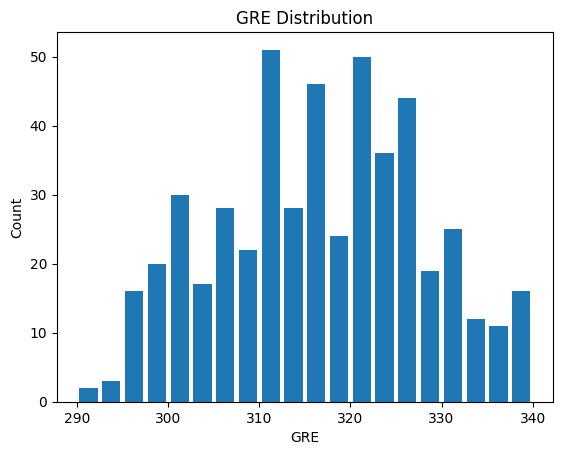

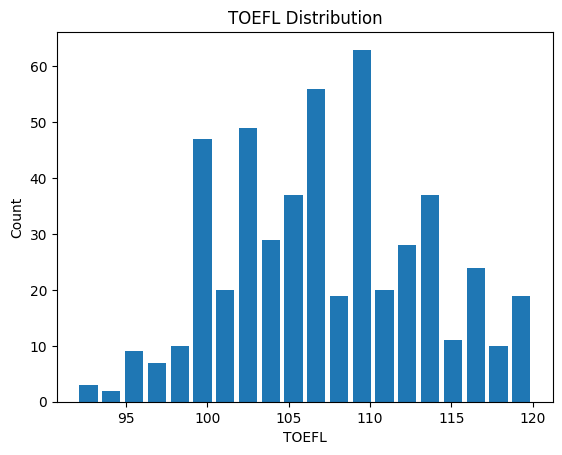

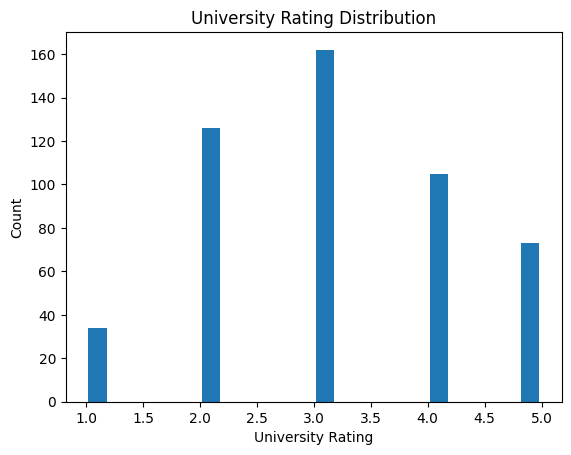

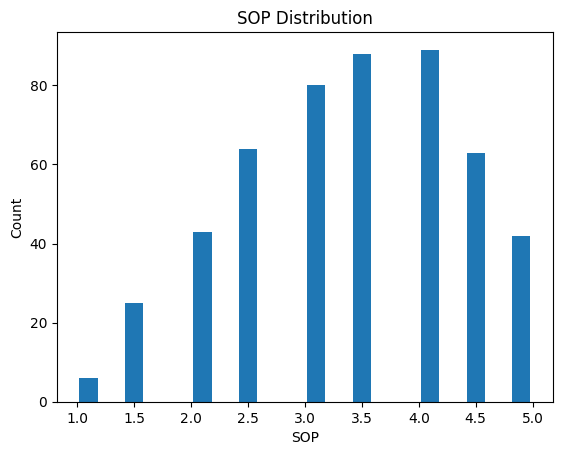

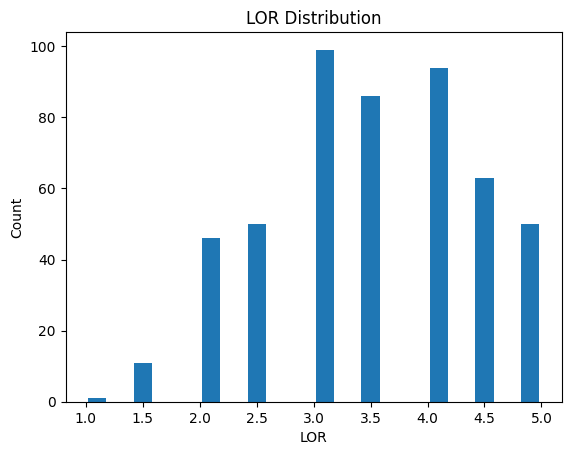

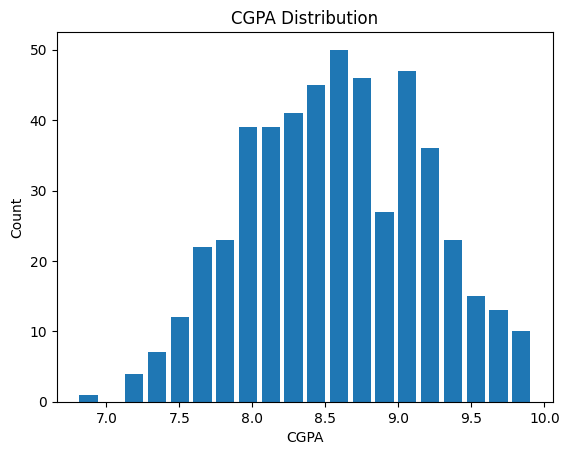

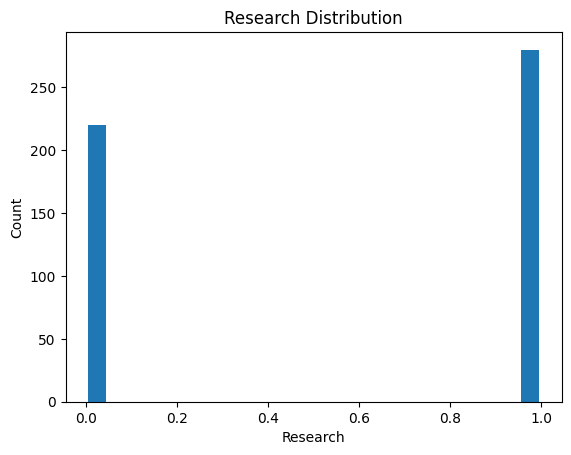

In [6]:
features = ['GRE','TOEFL','University Rating','SOP','LOR','CGPA','Research']
for col in features:
    plt.hist(df[col].dropna(), bins=20, rwidth=0.8)
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Regression target
y_reg = df['Probability']
X = df.drop('Probability', axis=1)

# Binary target for calibrated classification
HIGH_CHANCE_THRESHOLD = 0.8
y_bin = (y_reg >= HIGH_CHANCE_THRESHOLD).astype(int)

X_train, X_test, y_reg_train, y_reg_test, y_bin_train, y_bin_test = train_test_split(
    X, y_reg, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)
print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (400, 7)  Test size: (100, 7)


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create binned target for stratification (convert continuous → discrete bins)
def stratify_bins(y, n_bins=5):
    """Bin continuous y into quantiles for stratified CV."""
    return pd.qcut(y, q=n_bins, labels=False, duplicates='drop')

# Prepare stratified folds safely
y_bins = stratify_bins(y_reg_train)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models and grids
pipelines = {
    "LinearRegression": (
        Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("model", LinearRegression())
        ]),
        {}
    ),
    "Lasso": (
        Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("model", Lasso())
        ]),
        {"model__alpha": [0.01, 0.1, 1.0]}
    ),
    "RandomForest": (
        Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("model", RandomForestRegressor(random_state=42))
        ]),
        {"model__n_estimators": [100, 200], "model__max_depth": [None, 5, 10]}
    ),
}

# Run CV for each model
records = []
for name, (pipe, grid) in pipelines.items():
    print(f"Running {name}...")
    gs = GridSearchCV(pipe, grid, cv=cv.split(X_train, y_bins), scoring='r2', n_jobs=-1)
    gs.fit(X_train, y_reg_train)
    records.append([name, gs.best_params_, gs.best_score_])

# Show comparison
results_df = pd.DataFrame(records, columns=['Model', 'Best_Params', 'CV_R2'])
display(results_df)

Running LinearRegression...
Running Lasso...
Running RandomForest...


,Model,Best_Params,CV_R2
0,LinearRegression,{},0.805161
1,Lasso,{'model__alpha': 0.01},0.798528
2,RandomForest,"{'model__max_depth': 5, 'model__n_estimators':...",0.784990


 Best model: LinearRegression
RMSE = 0.0562
MAE  = 0.0399
R²   = 0.8520


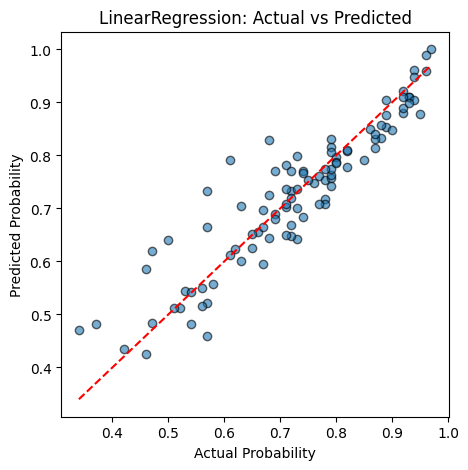

In [13]:
# Pick the best-performing regression model from GridSearchCV results
best_name = results_df.loc[results_df['CV_R2'].idxmax(), 'Model']
best_params = results_df.loc[results_df['CV_R2'].idxmax(), 'Best_Params']

best_model = pipelines[best_name][0]
if isinstance(best_params, dict):
    for k, v in best_params.items():
        if k.startswith("model__"):
            best_model.set_params(**{k: v})

best_model.fit(X_train, y_reg_train)
y_pred = best_model.predict(X_test)

#  Version-safe metrics (manual RMSE)
rmse = mean_squared_error(y_reg_test, y_pred) ** 0.5
mae  = mean_absolute_error(y_reg_test, y_pred)
r2   = r2_score(y_reg_test, y_pred)

print(f" Best model: {best_name}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

# Scatter: Actual vs Predicted
plt.figure(figsize=(5,5))
plt.scatter(y_reg_test, y_pred, alpha=0.6, edgecolor="k")
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], "--", color="red")
plt.xlabel("Actual Probability")
plt.ylabel("Predicted Probability")
plt.title(f"{best_name}: Actual vs Predicted")
plt.show()


In [14]:
# If Linear Regression, show coefficients
if best_name == "LinearRegression":
    lr_model = best_model.named_steps['model']
    coef_df = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": lr_model.coef_
    }).sort_values("Coefficient", ascending=False)
    print(" Feature influence (positive → increases admission probability):")
    display(coef_df)
else:
    print("ℹ Not a linear model — skipping coefficient table.")

 Feature influence (positive → increases admission probability):


,Feature,Coefficient
5,CGPA,0.076005
1,TOEFL,0.017959
0,GRE,0.015919
4,LOR,0.015129
6,Research,0.011956
2,University Rating,0.005769
3,SOP,0.000165


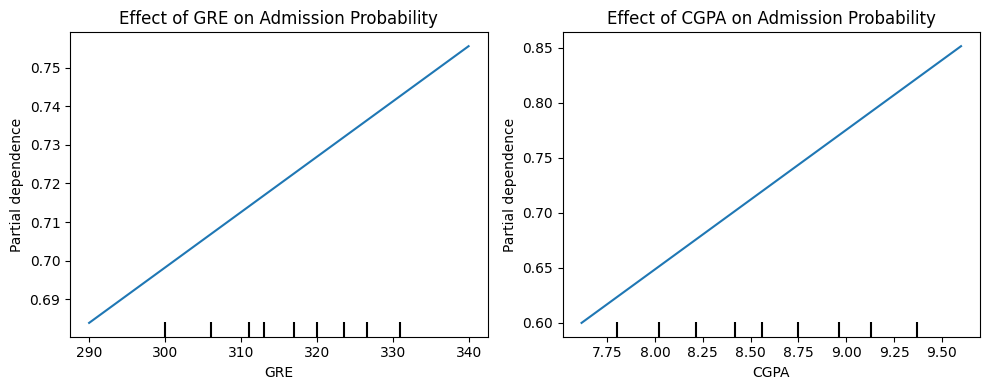

In [15]:
from sklearn.inspection import PartialDependenceDisplay

# Plot how GRE and CGPA affect predicted probability
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
PartialDependenceDisplay.from_estimator(best_model, X, ['GRE'], ax=ax[0])
PartialDependenceDisplay.from_estimator(best_model, X, ['CGPA'], ax=ax[1])
ax[0].set_title("Effect of GRE on Admission Probability")
ax[1].set_title("Effect of CGPA on Admission Probability")
plt.tight_layout()
plt.show()

 Best Classifier: {'clf__max_depth': 5, 'clf__n_estimators': 100}  | CV ROC-AUC: 0.9765086038961039
ROC-AUC = 0.9654
Brier Score = 0.0806


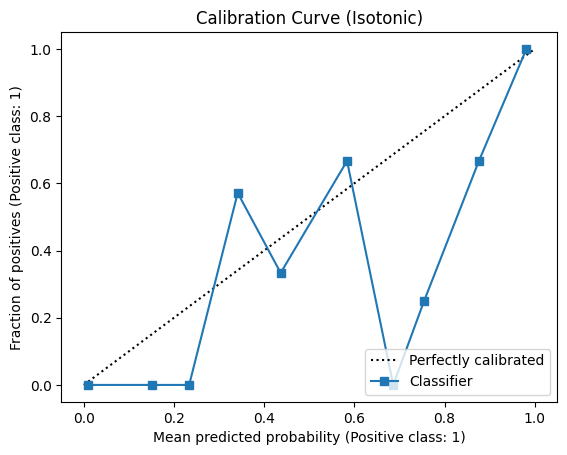

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import roc_auc_score, brier_score_loss, accuracy_score, f1_score, confusion_matrix

# Pipeline for classification
clf_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 5, 10]
}

# GridSearchCV for classifier
clf_gs = GridSearchCV(clf_pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
clf_gs.fit(X_train, y_bin_train)
print(" Best Classifier:", clf_gs.best_params_, " | CV ROC-AUC:", clf_gs.best_score_)

# Version-safe handling for CalibratedClassifierCV
try:
    #  For newer sklearn (>=1.0)
    calib_clf = CalibratedClassifierCV(estimator=clf_gs.best_estimator_, method='isotonic', cv=5)
except TypeError:
    #  Fallback for older sklearn (<1.0)
    calib_clf = CalibratedClassifierCV(base_estimator=clf_gs.best_estimator_, method='isotonic', cv=5)

# Fit calibrated classifier
calib_clf.fit(X_train, y_bin_train)

# Evaluate on test
proba = calib_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_bin_test, proba)
brier = brier_score_loss(y_bin_test, proba)
print(f"ROC-AUC = {auc:.4f}")
print(f"Brier Score = {brier:.4f}")

# Plot calibration curve
CalibrationDisplay.from_predictions(y_bin_test, proba, n_bins=10)
plt.title("Calibration Curve (Isotonic)")
plt.show()


In [18]:
def evaluate_thresholds(proba, y_true, df_meta, thresholds=(0.3,0.5,0.7), cost_fp=1.0, cost_fn=5.0):
    """
    Sweep decision thresholds and compute cost-based utility & fairness by subgroup.
    """
    best_thr, best_util = None, -1e9
    for thr in thresholds:
        y_pred = (proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        util = -(fp*cost_fp + fn*cost_fn)
        acc, f1 = accuracy_score(y_true, y_pred), f1_score(y_true, y_pred)
        print(f"thr={thr:.2f} → acc={acc:.3f} f1={f1:.3f} utility={util:.1f}")
        if util > best_util: best_util, best_thr = util, thr

    print(f"\n Recommended threshold = {best_thr:.2f}")

    # Fairness metrics by subgroup
    if 'Research' in df_meta.columns:
        for val in sorted(df_meta['Research'].unique()):
            mask = df_meta['Research'] == val
            acc = accuracy_score(y_true[mask], (proba[mask] >= best_thr).astype(int))
            print(f"Research={val}: acc={acc:.3f}")

    if 'University Rating' in df_meta.columns:
        for val in sorted(df_meta['University Rating'].unique()):
            mask = df_meta['University Rating'] == val
            acc = accuracy_score(y_true[mask], (proba[mask] >= best_thr).astype(int))
            print(f"UnivRating={val}: acc={acc:.3f}")

    return best_thr

best_thr = evaluate_thresholds(proba, y_bin_test, X_test)


thr=0.30 → acc=0.870 f1=0.827 utility=-13.0
thr=0.50 → acc=0.870 f1=0.800 utility=-33.0
thr=0.70 → acc=0.880 f1=0.800 utility=-40.0

 Recommended threshold = 0.30
Research=0: acc=0.886
Research=1: acc=0.857
UnivRating=1: acc=0.889
UnivRating=2: acc=0.957
UnivRating=3: acc=0.839
UnivRating=4: acc=0.706
UnivRating=5: acc=0.950


In [19]:
# Input order: GRE, TOEFL, University Rating, SOP, LOR, CGPA, Research
ex1 = [[337, 118, 4, 4.5, 4.5, 9.65, 0]]
ex2 = [[320, 113, 2, 2.0, 2.5, 8.64, 1]]

p1 = best_model.predict(ex1)[0]*100
p2 = best_model.predict(ex2)[0]*100
print(f"Chance of admission (Example 1): {p1:.2f}%")
print(f"Chance of admission (Example 2): {p2:.2f}%")

Chance of admission (Example 1): 92.78%
Chance of admission (Example 2): 74.08%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
